In [28]:
import kagglehub
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

In [29]:
path = kagglehub.dataset_download("fronkongames/steam-games-dataset")

print("保存先パス:", path)

csv_path = os.path.join(path, "games.csv")

df = pd.read_csv(csv_path, index_col=False, quotechar='"')
df.head()

保存先パス: /Users/kavuk/.cache/kagglehub/datasets/fronkongames/steam-games-dataset/versions/31


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,2539430,Black Dragon Mage Playtest,"Aug 1, 2023",0 - 0,0,0,0.00,0,0,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,https://shared.akamai.steamstatic.com/store_it...
1,496350,Supipara - Chapter 1 Spring Has Come!,"Jul 29, 2016",0 - 20000,0,0,5.24,65,0,"Springtime, April: when the cherry trees come ...",...,8,0,8,0,minori,MangaGamer,"Single-player,Steam Trading Cards,Steam Cloud,...",Adventure,"Adventure,Visual Novel,Anime,Cute",https://shared.akamai.steamstatic.com/store_it...
2,1034400,Mystery Solitaire The Black Raven,"May 6, 2019",0 - 20000,0,0,4.99,0,0,"Immerse yourself in the most beloved, mystical...",...,0,0,0,0,Somer Games,8floor,"Single-player,Family Sharing",Casual,"Casual,Card Game,Solitaire,Puzzle,Hidden Objec...",https://shared.akamai.steamstatic.com/store_it...
3,3292190,버튜버 파라노이아 - Vtuber Paranoia,"Oct 31, 2024",0 - 20000,1,0,8.99,0,1,"synopsis 'Hello, I'm Hiyoro, a new YouTuber!' ...",...,0,0,0,0,유진게임즈,유진게임즈,"Single-player,Steam Achievements,Family Sharing","Casual,Indie,Simulation",NaN,https://shared.akamai.steamstatic.com/store_it...
4,3631080,Maze Quest VR,"Apr 24, 2025",0 - 20000,0,0,4.99,0,0,Its not just a Maze; its a Quest! Enter the ca...,...,0,0,0,0,Reality Expanded LLC,Reality Expanded LLC,"Single-player,VR Only,Steam Leaderboards,Famil...","Action,Early Access",NaN,https://shared.akamai.steamstatic.com/store_it...


In [30]:
# 1. 'DiscountDLC count' を 2つに分ける（もし中身が混ざっているなら）
# もし単に名前が間違っているだけなら、rename でOK
df = df.rename(columns={'DiscountDLC count': 'Discount'})

# 2. 特徴量として使わなさそうな「画像」や「URL」を削る（DMLのSELECT的な操作）
drop_cols = ['Header image', 'Website', 'Support url', 'Support email', 'Metacritic url']
df_clean = df.drop(columns=drop_cols)

# 3. 欠損値（NaN）の処理
df_clean = df_clean.dropna(subset=['Price', 'Peak CCU'])

# スペースをアンダースコアに置換
df.columns = [c.replace(' ', '_') for c in df.columns]

In [31]:
df['log_ccu'] = np.log(df['Peak_CCU'] + 1)

In [33]:
zero_count = (df['Peak_CCU'] == 0).sum()
print(f"同時接続ゼロのゲーム数: {zero_count} / 全体: {len(df)}")

print(f"log_ccu の最大値: {df['log_ccu'].max()}")

同時接続ゼロのゲーム数: 102935 / 全体: 122611
log_ccu の最大値: 13.829351331025592


In [37]:
print(df.columns)

Index(['AppID', 'Name', 'Release_date', 'Estimated_owners', 'Peak_CCU',
       'Required_age', 'Price', 'Discount', 'About_the_game',
       'Supported_languages', 'Full_audio_languages', 'Reviews',
       'Header_image', 'Website', 'Support_url', 'Support_email', 'Windows',
       'Mac', 'Linux', 'Metacritic_score', 'Metacritic_url', 'User_score',
       'Positive', 'Negative', 'Score_rank', 'Achievements', 'Recommendations',
       'Notes', 'Average_playtime_forever', 'Average_playtime_two_weeks',
       'Median_playtime_forever', 'Median_playtime_two_weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies',
       'log_ccu'],
      dtype='object')


In [38]:
df.sample(n=30)

,AppID,Name,Release_date,Estimated_owners,Peak_CCU,Required_age,Price,Discount,About_the_game,Supported_languages,...,Median_playtime_forever,Median_playtime_two_weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies,log_ccu
69306,1968240,Escape If You Can,"Jun 26, 2022",0 - 20000,0,0,0.99,0,0,"Quick and easy, little game. You have to escap...",...,0,0,0,3dreals,3dreals,"Single-player,Family Sharing","Adventure,Indie",NaN,https://shared.akamai.steamstatic.com/store_it...,0.000000
52370,841270,Trap welcome to Beryl Part 1,"May 2, 2018",50000 - 100000,0,0,0.00,0,1,"Important! Only the first chapter is free, to ...",...,0,0,0,Jucar,Il Pleut,Single-player,"Adventure,Indie","Indie,Adventure,Violent,Gore,Horror,Free to Pl...",https://shared.akamai.steamstatic.com/store_it...,0.000000
90456,1025390,My Arctic Farm,"Feb 22, 2019",0 - 20000,0,0,0.99,90,0,My Arctic Farm is a farm building simulation g...,...,0,0,0,BIP Media,Plug In Digital,"Single-player,Family Sharing","Casual,Simulation","Casual,Simulation",https://shared.akamai.steamstatic.com/store_it...,0.000000
63262,1871350,OS:Memories,"Feb 9, 2022",0 - 20000,1,0,6.99,0,0,Investigate a computer [/] You were just the o...,...,0,0,0,BASI Studios,BASI Studios,"Single-player,Family Sharing","Indie,Simulation","Simulation,Casual,Short,Story Rich,Life Sim,Pu...",https://shared.akamai.steamstatic.com/store_it...,0.693147
23786,11130,Sherlock Holmes: The Mystery of the Mummy,"Aug 6, 2009",100000 - 200000,0,0,0.00,0,0,"Inspired by The adventures of Sherlock Holmes,...",...,0,199,0,Frogwares,Frogwares,Single-player,Adventure,"Adventure,Point & Click,Detective,Puzzle,Myste...",https://shared.akamai.steamstatic.com/store_it...,0.000000
110218,3508060,shutterbuds,"May 2, 2025",0 - 0,0,0,0.00,0,0,Explore a National Park with up to 3 of your p...,...,0,0,0,Drunkey Monkey Games,Champlain College,"Single-player,Multi-player,Co-op,Online Co-op,...","Adventure,Casual,Free To Play",NaN,https://shared.akamai.steamstatic.com/store_it...,0.000000
20378,1912420,Sunshine Shuffle,"May 24, 2023",20000 - 50000,0,0,5.99,40,0,Sunshine Shuffle is a narrative poker adventur...,...,0,104,0,Strange Scaffold,Strange Scaffold,"Single-player,Steam Achievements,Full controll...",Casual,"Gambling,Card Game,Visual Novel,Collectathon,C...",https://shared.akamai.steamstatic.com/store_it...,0.000000
18989,806140,Achievements printer,"Mar 2, 2018",500000 - 1000000,4,0,0.49,0,0,Achievement printer is simple basketball game....,...,0,137,0,Easy game,Game for people,"Single-player,Steam Achievements,Steam Trading...","Action,Casual,Indie,Sports","Casual,Indie,Sports,Action",https://shared.akamai.steamstatic.com/store_it...,1.609438
27190,1783900,Debt - Chasing Treasure,"Feb 25, 2022",0 - 20000,0,0,4.99,0,0,WARNING This game may trigger seizures in peop...,...,0,0,0,Alien Finger,Alien Finger,"Single-player,Family Sharing","Action,Adventure,Indie,Simulation","Exploration,Psychological Horror,Hidden Object...",https://shared.akamai.steamstatic.com/store_it...,0.000000
61924,1214760,Shine's Adventures 4 (Nightmare),"Mar 13, 2020",0 - 20000,0,0,1.79,40,0,The following is the link to the bundle of'Shi...,...,0,0,0,ShineProject,ShineProject,"Single-player,Steam Achievements,Steam Leaderb...","Action,Adventure,Casual,RPG,Strategy","Action,Adventure,RPG,Casual,Strategy,Gore,Violent",https://shared.akamai.steamstatic.com/store_it...,0.000000


In [39]:
df.describe()

,AppID,Peak_CCU,Required_age,Price,Discount,About_the_game,Metacritic_url,Positive,Negative,Score_rank,Achievements,Recommendations,Notes,Average_playtime_two_weeks,Median_playtime_forever,Median_playtime_two_weeks,Developers,log_ccu
count,1.226110e+05,1.226110e+05,122611.000000,122611.000000,122611.000000,122611.000000,122611.000000,122611.000000,1.226110e+05,1.226110e+05,40.000000,122611.000000,1.226110e+05,1.226110e+05,122611.000000,1.226110e+05,122611.000000,122611.000000
mean,1.985386e+06,5.459332e+01,0.167611,4.765091,18.353663,0.545856,2.564941,0.024549,1.044986e+03,1.691974e+02,99.175000,18.087015,9.618250e+02,2.080232e+02,13.789268,1.735705e+02,14.722170,0.333299
std,1.087595e+06,3.729452e+03,1.653591,12.531030,28.858970,14.516026,13.660559,1.394901,2.809173e+04,5.374645e+03,0.675107,141.493879,2.187880e+04,1.121768e+04,270.378053,1.120254e+04,294.509615,1.039445
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,98.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.063175e+06,0.000000e+00,0.000000,0.550000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,99.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
50%,1.907380e+06,0.000000e+00,0.000000,2.240000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,1.000000e+00,99.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
75%,2.869560e+06,0.000000e+00,0.000000,5.240000,40.000000,0.000000,0.000000,0.000000,3.700000e+01,1.000000e+01,100.000000,19.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
max,4.264350e+06,1.013936e+06,21.000000,999.980000,100.000000,3703.000000,97.000000,100.000000,7.642084e+06,1.173003e+06,100.000000,9821.000000,4.830455e+06,3.429544e+06,20088.000000,3.429544e+06,20088.000000,13.829351


In [10]:
# カラムごとの欠損値の個数を確認
print(df.isnull().sum())

# カラムごとの欠損率（%）を確認
# print(df.isnull().mean() * 100)

AppID                              0
Name                               1
Release_date                       0
Estimated_owners                   0
Peak_CCU                           0
Required_age                       0
Price                              0
Discount                           0
About_the_game                     0
Supported_languages             8449
Full_audio_languages               0
Reviews                            0
Header_image                  110541
Website                           81
Support_url                    72935
Support_email                  68469
Windows                        22263
Mac                                0
Linux                              0
Metacritic_score                   0
Metacritic_url                     0
User_score                    118355
Positive                           0
Negative                           0
Score_rank                         0
Achievements                  122571
Recommendations                    0
N

<Axes: >

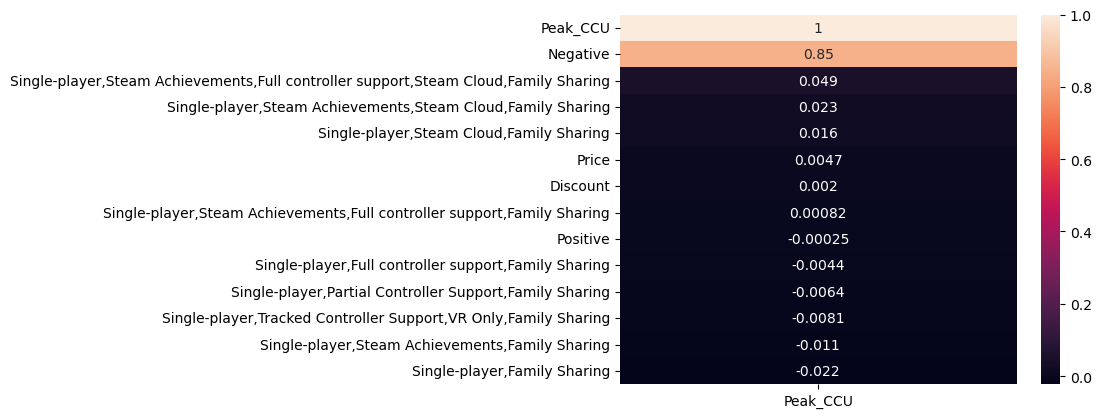

In [40]:
# 1. 数値系をまず選ぶ
num_cols = ['Peak_CCU', 'Positive', 'Negative', 'Price', 'Discount']

# 2. カテゴリ系は、出現数が多いものだけをダミー化して混ぜる
# 例：Genreだけ、かつ上位10個だけ
top_genres = df['Genres'].value_counts().nlargest(10).index
df_top_genres = pd.get_dummies(df[df['Genres'].isin(top_genres)]['Genres'], drop_first=True)

# 3. これらをガッチャンコしたのが「戦略的 df_selected」
df_selected = pd.concat([df[num_cols], df_top_genres], axis=1)

corr = df_selected.corr()
sns.heatmap(corr[['Peak_CCU']].sort_values(by='Peak_CCU', ascending=False), annot=True)

In [11]:
formula = "Peak_CCU ~ Positive"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Peak_CCU   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.007804
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.930
Time:                        20:19:08   Log-Likelihood:            -1.1823e+06
No. Observations:              122611   AIC:                         2.365e+06
Df Residuals:                  122609   BIC:                         2.365e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.6099     10.652      5.127      0.0

In [12]:
formula = "Peak_CCU ~ Positive + Discount + Price"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Peak_CCU   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.100
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.348
Time:                        20:19:56   Log-Likelihood:            -1.1823e+06
No. Observations:              122611   AIC:                         2.365e+06
Df Residuals:                  122607   BIC:                         2.365e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.4738     13.366      3.178      0.0

In [ ]:
# # 1. 数値データだけ取り出す or ダミー変数化
# X = pd.get_dummies(df.drop(['AppID', 'Name', 'Peak_CCU'], axis=1), drop_first=True)
# y = df['Peak_CCU']

# # 2. 標準化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 3. LassoCV（最適なλを自動で探してくれるモード）
# model = LassoCV(cv=5)
# model.fit(X_scaled, y)

# # 4. 生き残った変数を確認
# coeff_df = pd.DataFrame({'Feature': X.columns, 'Coef': model.coef_})
# print(coeff_df[coeff_df['Coef'] != 0])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

def dml_scratch(Y, D, X):
    # データを2つに分ける（Cross-fittingの最小構成）
    kf = KFold(n_splits=2)
    results = []

    for train_idx, test_idx in kf.split(X):
        # 訓練データとテストデータの分割
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        D_train, D_test = D[train_idx], D[test_idx]

        # 1. モデルA: Yの予測
        model_y = RandomForestRegressor(n_estimators=100)
        model_y.fit(X_train, Y_train)
        y_res = Y_test - model_y.predict(X_test) # Yの残差

        # 2. モデルB: Dの予測
        model_d = RandomForestRegressor(n_estimators=100)
        model_d.fit(X_train, D_train)
        d_res = D_test - model_d.predict(X_test) # Dの残差

        # 3. 最後にOLS（末石本の公式）
        # y_res = beta * d_res + epsilon を解く
        ols = LinearRegression(fit_intercept=False)
        ols.fit(d_res.reshape(-1, 1), y_res)
        results.append(ols.coef_[0])

    return np.mean(results)

In [ ]:
# 仮のデータ整形（Genreをダミー変数化している想定）
# Y: log_ccu, D: Price (or discount_flag), X: Genres_Action, Genres_RPG...

def estimate_cate_with_dml(df, outcome_col, treatment_col, feature_cols):
    Y = df[outcome_col].values
    D = df[treatment_col].values
    X = df[feature_cols].values
    
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    residuals_y = np.zeros(len(Y))
    residuals_d = np.zeros(len(D))
    
    # Step 1: 処置と結果の「ノイズ（背景）」をMLで予測して除去（直交化）
    for train_idx, test_idx in kf.split(X):
        # Y (CCU) の背景予測
        model_y = RandomForestRegressor(n_estimators=100, max_depth=5)
        model_y.fit(X[train_idx], Y[train_idx])
        residuals_y[test_idx] = Y[test_idx] - model_y.predict(X[test_idx])
        
        # D (Price) の背景予測
        model_d = RandomForestRegressor(n_estimators=100, max_depth=5)
        model_d.fit(X[train_idx], D[train_idx])
        residuals_d[test_idx] = D[test_idx] - model_d.predict(X[test_idx])

    # Step 2: CATEの推定
    # 残差 Y ~ CATE(X) * 残差 D という関係を利用する
    # シンプルに「残差Y / 残差D」を計算すると不安定なので、
    # 局所的な回帰や、さらにMLを使って CATE(X) を学習させる
    
    # 簡易的なCATE: 残差の比（本来はここもMLでXの関数として学習させる）
    cate_proxy = residuals_y / (residuals_d + 1e-9)
    
    return cate_proxy, residuals_y, residuals_d

# 実行イメージ
# features = [col for col in df.columns if 'Genres_' in col]
# df['cate'], res_y, res_d = estimate_cate_with_dml(df, 'log_ccu', 'Price', features)

In [ ]:
# 'Genres' カラムが "Action;RPG;Indie" のような形式だと仮定
# 1. セミコロンで分割してリスト化し、explodeで縦に展開
# 2. 空白除去(strip)をしてから、unique()で重複排除
unique_genres = df['Genres'].str.split(';').explode().str.strip().unique()

# 欠損値(NaN)が含まれる場合は除外
unique_genres = [g for g in unique_genres if pd.notna(g)]

print(f"見つかったジャンル数: {len(unique_genres)}")
print(unique_genres)

見つかったジャンル数: 13291
['Single-player,Steam Trading Cards,Steam Cloud,Family Sharing', 'Single-player,Family Sharing', 'Single-player,Steam Achievements,Family Sharing', 'Single-player,VR Only,Steam Leaderboards,Family Sharing', 'Single-player,Tracked Controller Support,VR Only,Family Sharing', 'Single-player,Steam Workshop,Steam Cloud,Family Sharing', 'Single-player,Full controller support,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Steam Cloud,Family Sharing,Steam Timeline', 'Single-player,Multi-player,PvP,Online PvP,Steam Achievements,Steam Trading Cards,Steam Cloud,Includes level editor,Family Sharing', 'Single-player,Steam Achievements,Partial Controller Support,Steam Cloud,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Steam Cloud,Remote Play Together,Family Sharing', 'Single-player,Partial Controller Support,Family Sharing', 'Single-player,Multi-playe

Neyman_Orthogonality_Proof.md  <-- 自力導出するならココ！  
    - DML_Algorithm_Steps.md         <-- スクラッチ実装の設計図.  
    - CATE_vs_ATE.md.
末石本（ATEとLATE）.  
GMMの直行条件→ネイマン直交→その他学習者（SとかTとか）→DML.  

ロードマップ:4章（行列表記と漸近理論）→3章（ATEとLATE）→5章（GMM）→論文（導出・理解(CATE・ネイマン直交・SとかTラーナー・DML)）→論文（実装）.  
5章（GMM）→論文（導出・理解(CATE・ネイマン直交・SとかTラーナー・DML)）→論文（実装）
Lasso
フリッシュ＝ウォー＝ロベル（FWL）定理